In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run2_chairs1k_size4'

In [4]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

1117 stroke records in the database.
280 clickedObj records in the database.


## generate group dataframe

In [5]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [6]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There was something wrong with this game 5976-3520ab05-033f-4cda-bb7f-8d93ab0956c4
There was something wrong with this game 0135-deee0e88-ce5a-48b1-99d5-cf1e3217a99f
There was something wrong with this game 4004-08fcac10-54da-4362-8b77-6869a2b4aa0a
There was something wrong with this game 5288-2608bf5a-2af4-438c-90df-032a479b3195
There was something wrong with this game 2153-fe370c60-795f-46f4-959e-4aa70ec7c4ed
There was something wrong with this game 2306-68150396-3082-458b-bf35-5683428df704
There was something wrong with this game 5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
There was something wrong with this game 8283-9b48bed2-3a8c-45ae-b706-649231363252
There was something wrong with this game 5428-1c065c92-f2c0-4c0f-bf37-9a7bc82fb832
There was something wrong with this game 1602-f09f5dc8-0f6a-46ab-9e09-ab12c700e9b5
There was something wrong with this game 3775-8f131e6c-5ac4-43ad-b290-c09b11dde8fa
Ther

In [7]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

_complete_games = ['7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82', '5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9', '3176-1391c021-32cc-4034-8811-4ddafef4280f',
                  '1217-816328d8-5486-410a-b18e-9578493b0f31', '1555-977bf072-b352-44e5-b00e-317349ddc158', '3663-5a7299be-30cf-4686-939e-b2f163df6889']

for i,g in enumerate(_complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                # calculate numStrokes 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                numStrokes.append(lastStrokeNum)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82 | 0 of 7: 
Analyzing game 5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9 | 1 of 7: 
Analyzing game 3176-1391c021-32cc-4034-8811-4ddafef4280f | 2 of 7: 
Analyzing game 1217-816328d8-5486-410a-b18e-9578493b0f31 | 3 of 7: 
Analyzing game 1555-977bf072-b352-44e5-b00e-317349ddc158 | 4 of 7: 
Analyzing game 3663-5a7299be-30cf-4686-939e-b2f163df6889 | 5 of 7: 


In [8]:
import sys

_path = '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7'

if _path not in sys.path:
    sys.path.insert(1, _path)
    
print sys.path

['', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/Users/megumisano/anaconda/envs/py27/lib/python27.zip', '/Users/megumisano/anaconda/envs/py27/lib/python2.7', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/plat-darwin', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/plat-mac', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/lib-tk', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/lib-old', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/lib-dynload', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/PIL', '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/IPython/extensions', '/Users/megumisano/.ipython', '/Users/megumisano/graphical_conventions/analysis/python']


In [7]:
sns.__version__

'0.9.0'

In [9]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
#D = D[D['gameID'] == '1180-2832f7d7-535a-4fb3-acf4-d40972f6d878']

# Just look at repeated trials and sort them by target and reps 
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
D

,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,meanPixelIntensity,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,1,control,deck_07,deck,0,pre,19.823,True,deck_07,12,0.0714,1044,87,86.5833,29,2.41667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,2,repeated,deck_05,deck,0,pre,10.001,True,deck_05,5,0.0583,971,194.2,283.699,28,5.6,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,3,repeated,deck_00,deck,0,pre,11.148,False,deck_06,7,0.0556,677,96.7143,57.5095,18,2.57143,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,4,control,deck_01,deck,0,pre,9.618,False,deck_03,6,0.0492,856,142.667,114.836,23,3.83333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,5,control,deck_03,deck,0,pre,21.78,True,deck_03,9,0.0489,1710,190,208.604,49,5.44444,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,6,repeated,deck_02,deck,0,pre,10.001,True,deck_02,4,0.0324,931,232.75,214.192,25,6.25,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,7,control,deck_04,deck,0,pre,8.032,True,deck_04,4,0.041,1016,254,57.0351,26,6.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,8,repeated,deck_06,deck,0,pre,11.418,True,deck_06,7,0.0732,1225,175,95.0368,32,4.57143,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,9,repeated,deck_02,deck,1,repeated,7.808,True,deck_02,5,0.0307,575,115,117.441,15,3,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,10,repeated,deck_00,deck,1,repeated,16.222,False,deck_06,12,0.0845,1489,124.083,111.114,38,3.16667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


##### see how previous trial accuracy affects numStrokes on current trial

In [10]:
falseNumStrokes = []
trueNumStrokes = []
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        if d['outcome'] == False:
            nextNumStrokes = D['outcome'][i+1]
            falseNumStrokes.append(nextNumStrokes)
        else:
            nextNumStrokes = D['outcome'][i+1]
            trueNumStrokes.append(nextNumStrokes)

In [11]:
meanNumStrokesGivenFalse = sum(falseNumStrokes)/float(len(falseNumStrokes))
meanNumStrokesGivenTrue =  sum(trueNumStrokes)/float(len(trueNumStrokes))
print meanNumStrokesGivenFalse, meanNumStrokesGivenTrue

0.634146341463 0.868686868687


### confusion matrix for each category

In [149]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

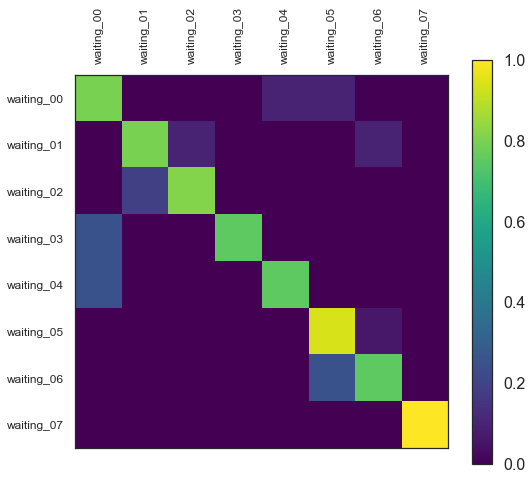

In [157]:
h.get_confusion_matrix(D, 'waiting', 4)

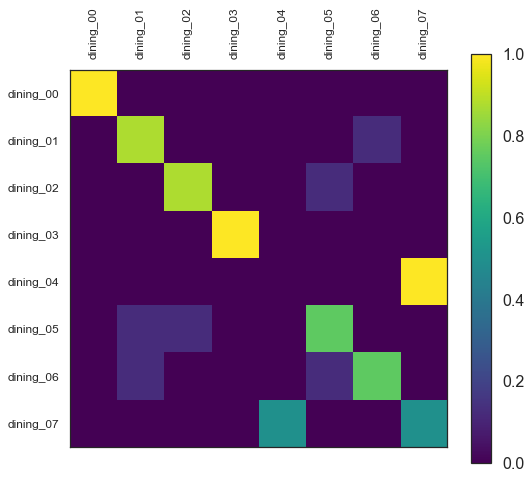

In [158]:
h.get_confusion_matrix(D, 'dining', 4)

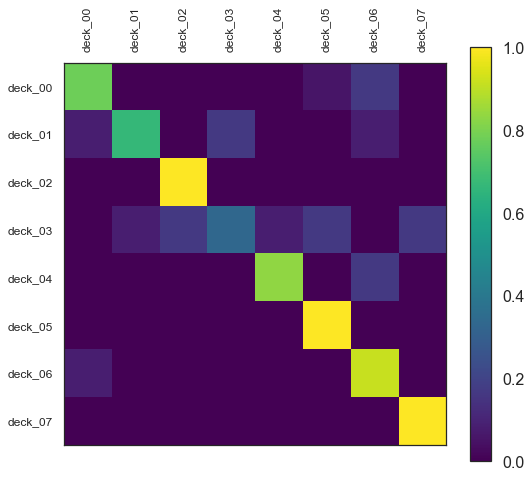

In [159]:
h.get_confusion_matrix(D, 'deck', 4)

In [196]:
_D = D[D['condition'] == 'repeated']

In [203]:
_D_first = _D[((_D['repetition'] <= 3) & (_D['phase'] != 'post')) || (_D['repetition'] == 0)]
_D_last = _D[_D['repetition'] >= 4]

SyntaxError: invalid syntax (<ipython-input-203-f6c1afc706f1>, line 1)

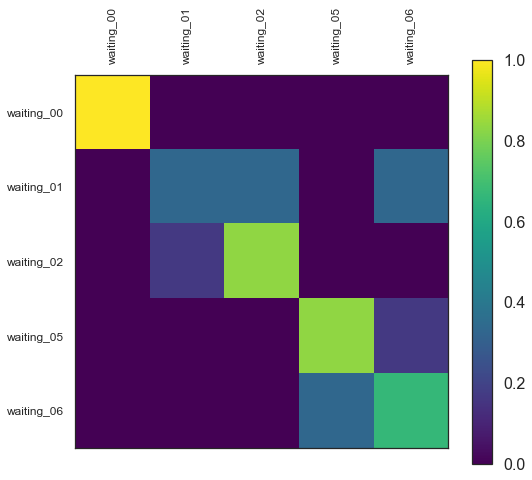

In [223]:
category = 'waiting'
set_size = 4

_D = D[D['condition'] == 'repeated']
_D = _D[_D['repetition'] >= 5]
target_list = _D['target'].tolist()
obj_list_ = []
obj_list = []
objlist = h.CATEGORY_TO_OBJECT_run2[category]
for obj in objlist[:set_size*2]:
    obj_list_.append(obj)
for i in obj_list_:
    if i in target_list:
        obj_list.append(i)

## initialize confusion matrix 
confusion = np.zeros((len(obj_list), len(obj_list)))

## generate confusion matrix by incrementing each cell 
for i, d in _D.iterrows():
    if d['category'] == category:
        targ_ind = obj_list.index(d['target'])
        chosen_ind = obj_list.index(d['response'])
        confusion[targ_ind, chosen_ind] += 1

## normalize confusion matrix 
normed = np.zeros((len(obj_list), len(obj_list)))
for i in np.arange(len(confusion)):
    normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])

## plot confusion matrix 
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
#plt.savefig('./plots/confusion_matrix_all.pdf')
#plt.close(fig)

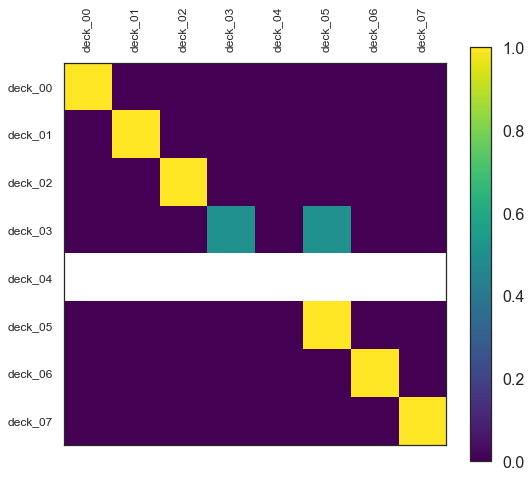

In [200]:
h.get_confusion_matrix(_D_last, 'deck', 4)

## visualize behavioral measures over time

In [172]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [106]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

0.82916666666666672

(0.5, 1.0)

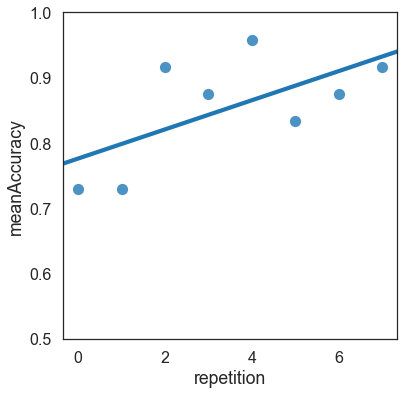

In [112]:
mean_accuracy_list = []
for i in range(0,8):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)

D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,8)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5, 1.0])

### plot time series during repetition phase 

##### individual measures across reps (repeated trials only)

In [60]:
# What is the measure that you want to visualize across reps? 
dv = 'drawDuration' 

In [25]:
# D0 = h.ts_repeated(D,
#                                     var=dv,
#                                     limit=20, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
#                                     save_plot=False,
#                                     plot_dir=plot_dir)

##### individual measures across reps (repeated + control)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


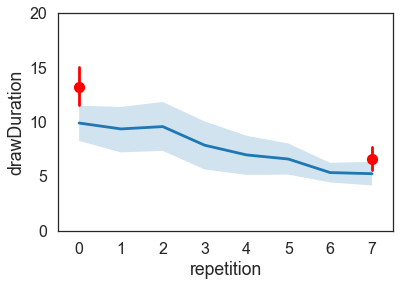

In [61]:
h.ts_repeated_control(D, 
                        var=dv,
                        limit=20, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

## gameIDs 
## objects 

##### 4 measures (2x2) across reps (repeated + control) 

In [11]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3='numCurvesPerStroke'

In [15]:
save_plot=False
plot_dir='./plots'

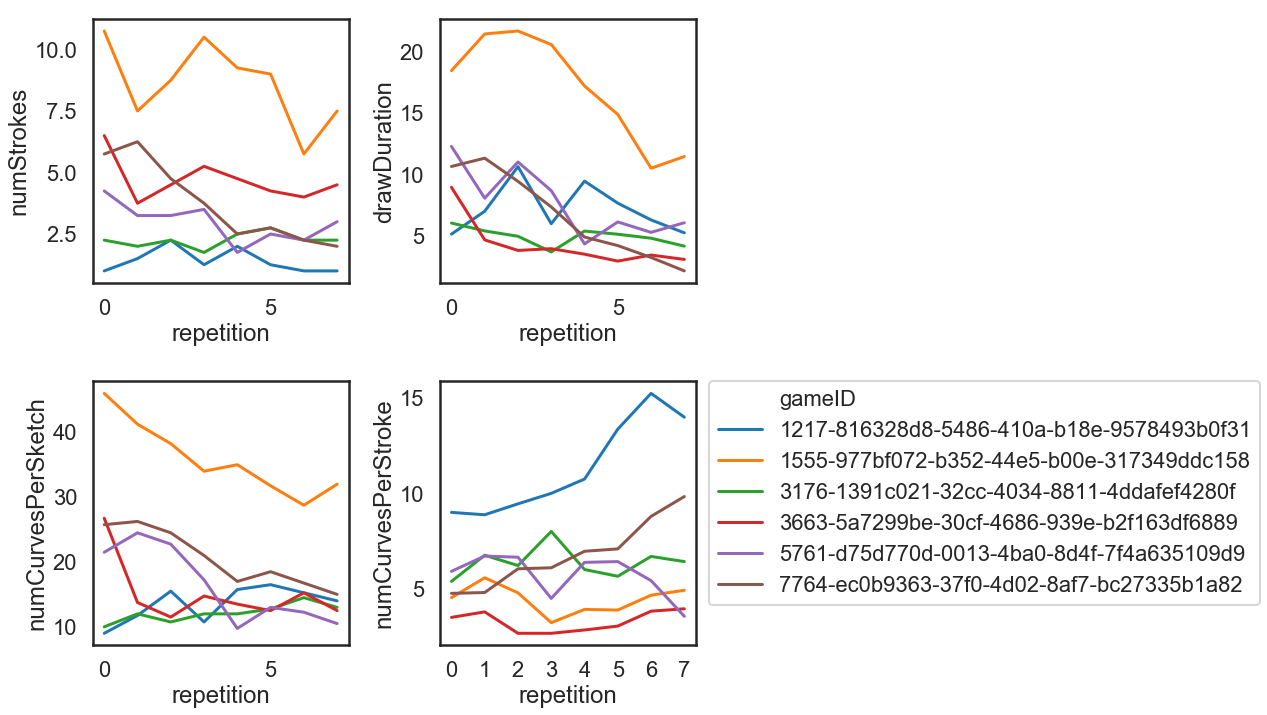

In [31]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

###  Subhelper 1

def collapse_within_repetition(D, var, condition, numReps):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()).replace(1,numReps-1)


D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

## collapsing across objects within repetition (within pair) 
## and only aggregating repeated trials into this sub-dataframe
D0 = collapse_within_repetition(D, var0, 'repeated', 8)
D1 = collapse_within_repetition(D, var1, 'repeated', 8)
D2 = collapse_within_repetition(D, var2, 'repeated', 8)
D3 = collapse_within_repetition(D, var3, 'repeated', 8)

#fig = plt.figure(figsize=(12,12))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

## make sure that the number of timepoints now per gameID is equal to the number of repetitions in the game
num_reps = len(np.unique(D.repetition.values))
assert D0.groupby('gameID')['gameID'].count()[0]==num_reps    

sns.lineplot(data=D0,
           x='repetition',
           hue='gameID',
           #unit='gameID',
           y=var0,
           ax=ax0,
           legend = False)

sns.lineplot(data=D1,
           x='repetition',
           hue='gameID',
           #unit='gameID',
           y=var1,
           ax=ax1,
           legend = False)

sns.lineplot(data=D2,
           x='repetition',
           hue='gameID',
           #unit='gameID',
           y=var2,
           ax=ax2,
           legend = False)

sns.lineplot(data=D3,
           x='repetition',
           hue='gameID',
           #unit='gameID',
           y=var3,
           ax=ax3)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future

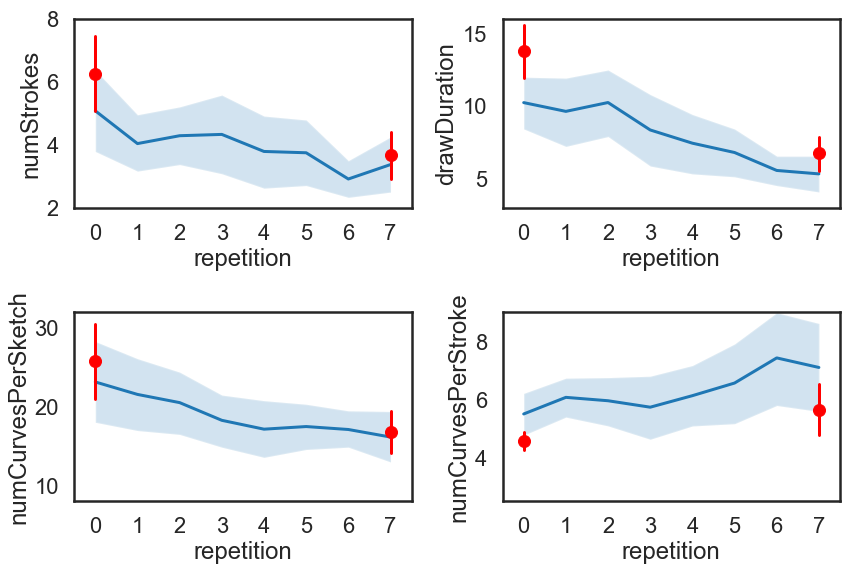

In [13]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [173]:
### change outcome booleans to numbers 
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

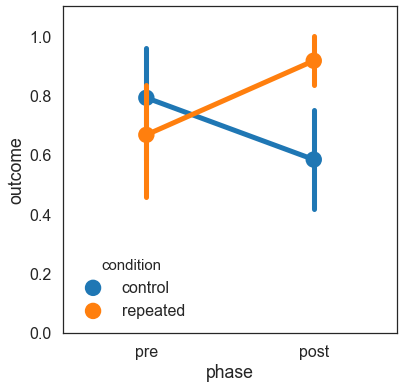

In [138]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

##### compare draw duration in pre and post phases (repeated vs control)

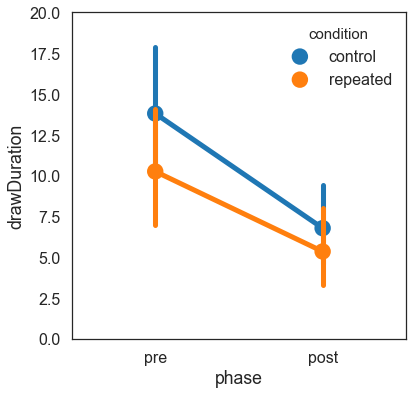

In [132]:
reload(h)
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

 ### visualize how sketches are changing across repetitions

In [63]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py'>

In [175]:
# h.print_repeated_sketches(D,
#                                      complete_games,
#                                      sketch_dir)

In [18]:
# print_control_sketches(D,
#                                    complete_games,
#                                    sketch_dir)

##### print repeated condition sketches 

Printing out sketches from game: 7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82
Printing out sketches from game: 5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9
Printing out sketches from game: 3176-1391c021-32cc-4034-8811-4ddafef4280f
Printing out sketches from game: 1217-816328d8-5486-410a-b18e-9578493b0f31
Printing out sketches from game: 1555-977bf072-b352-44e5-b00e-317349ddc158
Printing out sketches from game: 3663-5a7299be-30cf-4686-939e-b2f163df6889
Printing out sketches from game: 8573-60132f17-e4db-4d3e-a49f-4b17867f32d0


ValueError: max() arg is an empty sequence

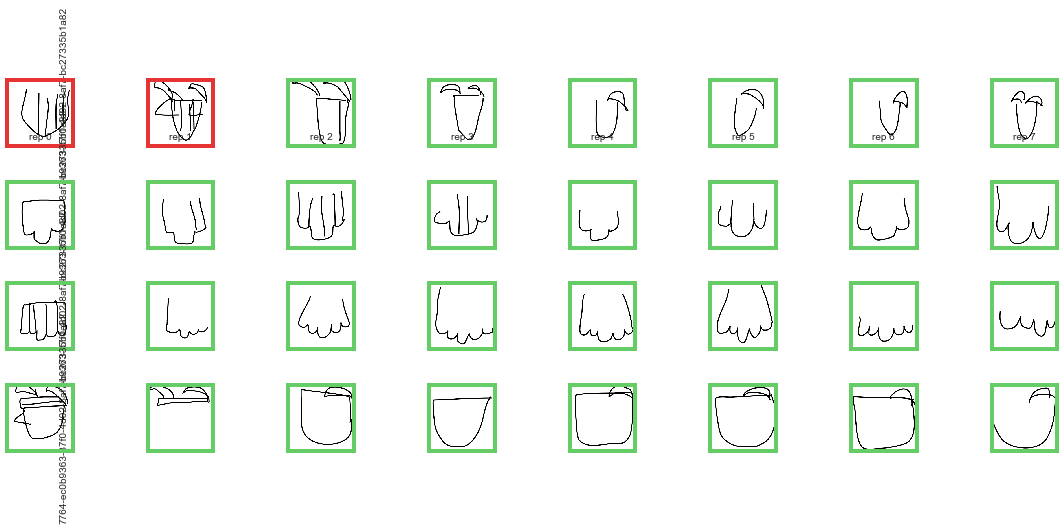

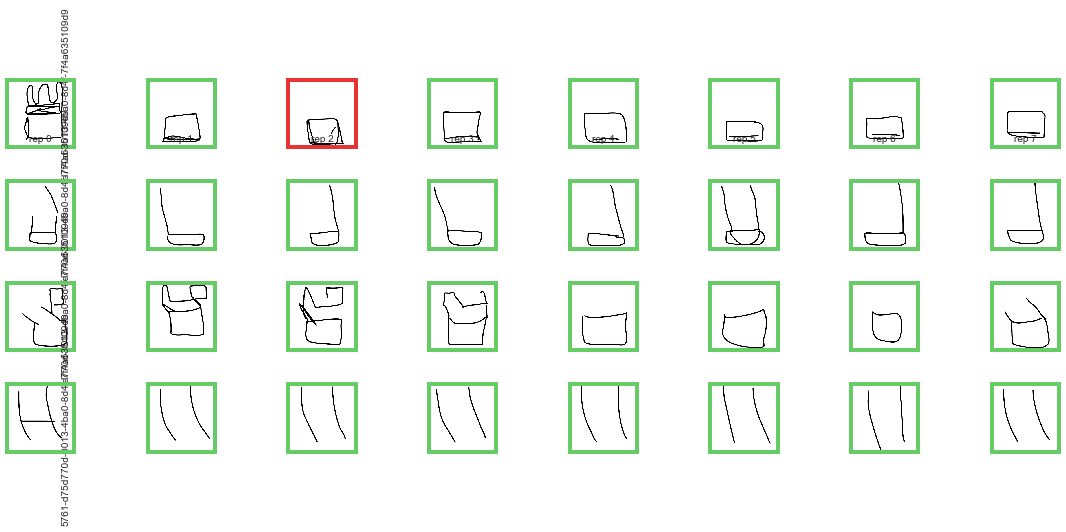

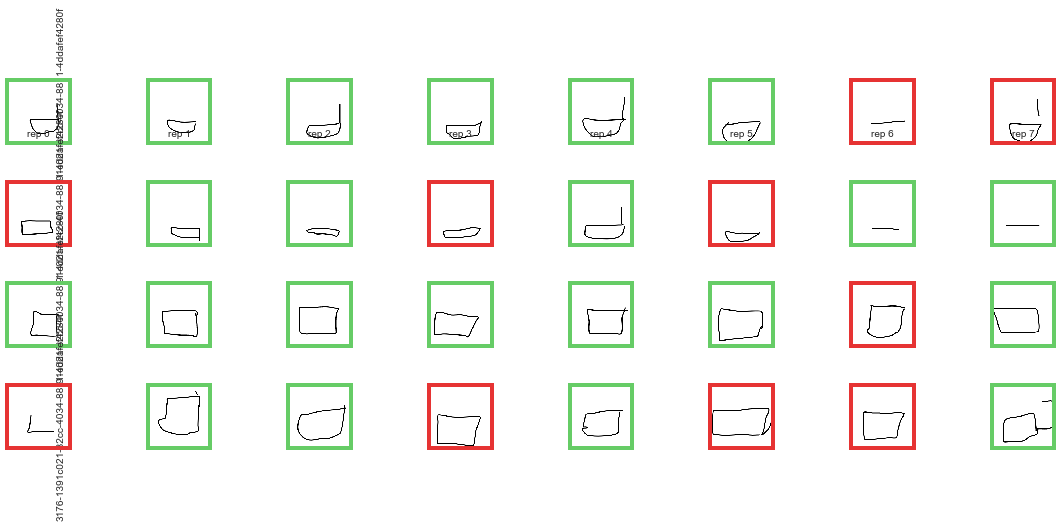

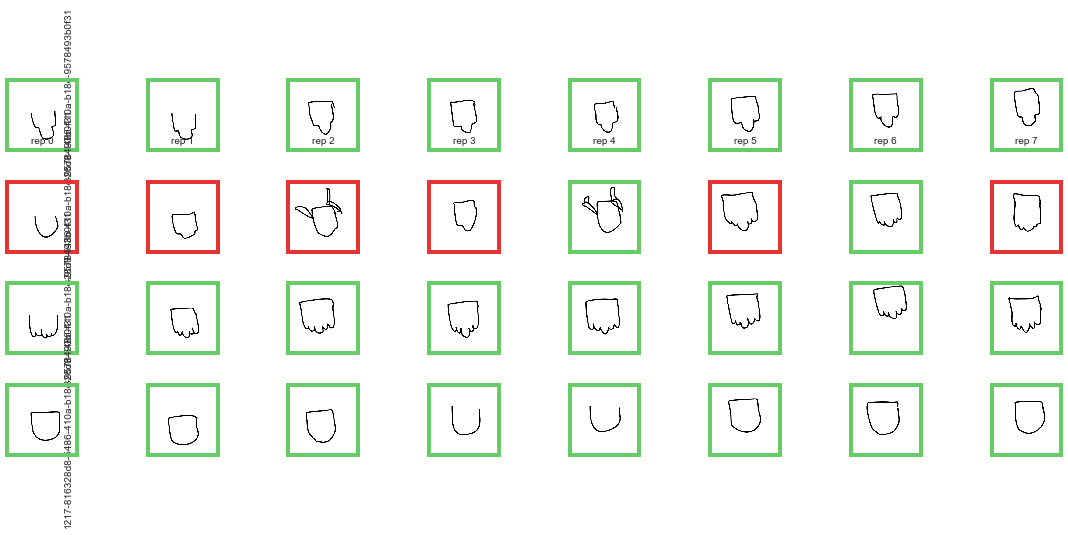

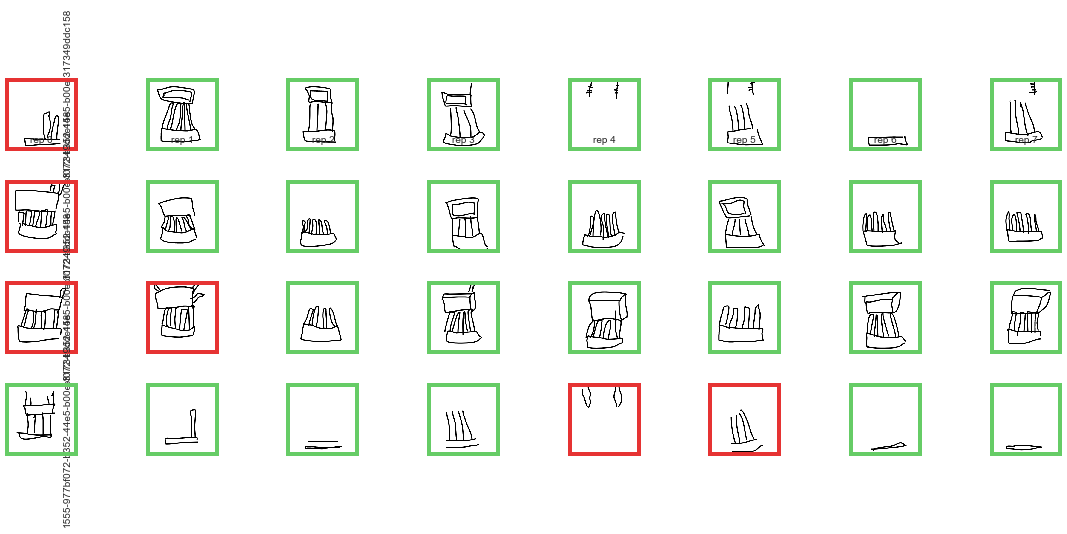

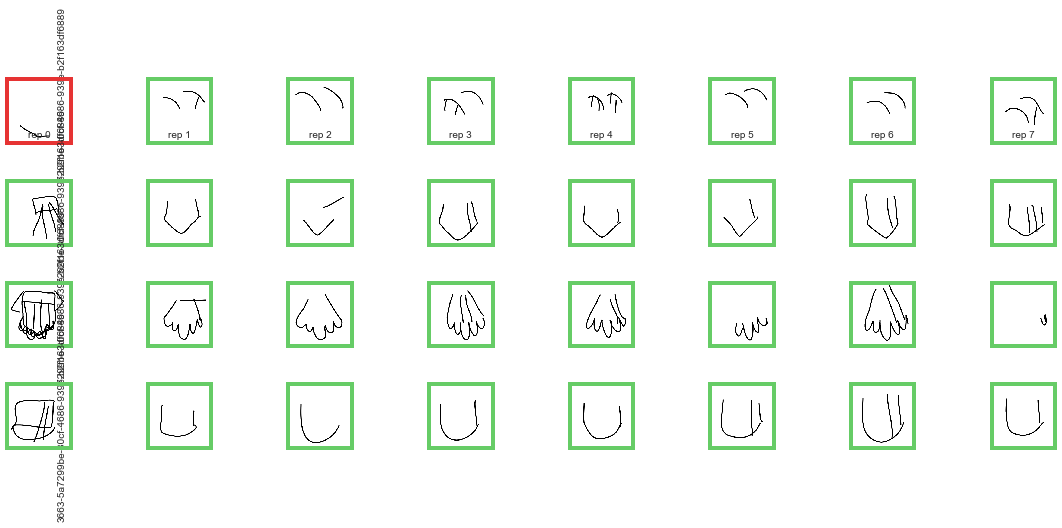

In [29]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,8,_i)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i-1 < 8) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=10)
            if (_i-1)%8==0:
                plt.ylabel(g,fontsize=10) # _d['target'] 

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()

##### print control condition sketches

In [ ]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['control']
    for tt in trial_types:
        _D = D[(D.condition=='control') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,2,_i)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i-1 < 2) & (tt in 'control'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if (_i-1)%2==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'control','{}_{}.pdf'.format(g,category))     
        if not os.path.exists(os.path.join(sketch_dir,'control')):
            os.makedirs(os.path.join(sketch_dir,'control'))
        #plt.savefig(os.path.join(sketch_dir,'control',filepath))
        #plt.close(fig)

##### printing actual sketches next to repeated sketches

In [165]:
index = range(1, 37)

In [166]:
new_index = filter(lambda x: x%9!=0, index)

Printing out sketches from game: 7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82
Printing out sketches from game: 5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9
Printing out sketches from game: 3176-1391c021-32cc-4034-8811-4ddafef4280f
Printing out sketches from game: 1217-816328d8-5486-410a-b18e-9578493b0f31
Printing out sketches from game: 1555-977bf072-b352-44e5-b00e-317349ddc158
Printing out sketches from game: 3663-5a7299be-30cf-4686-939e-b2f163df6889
Printing out sketches from game: 8573-60132f17-e4db-4d3e-a49f-4b17867f32d0


ValueError: max() arg is an empty sequence

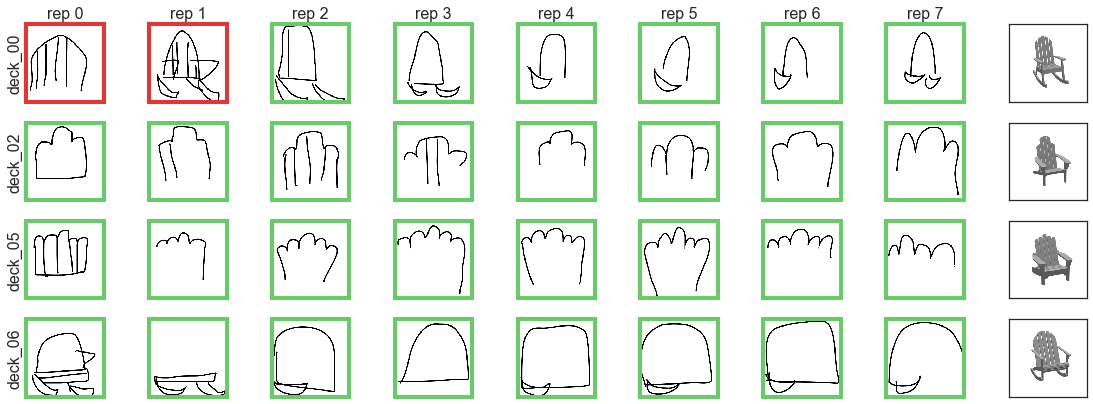

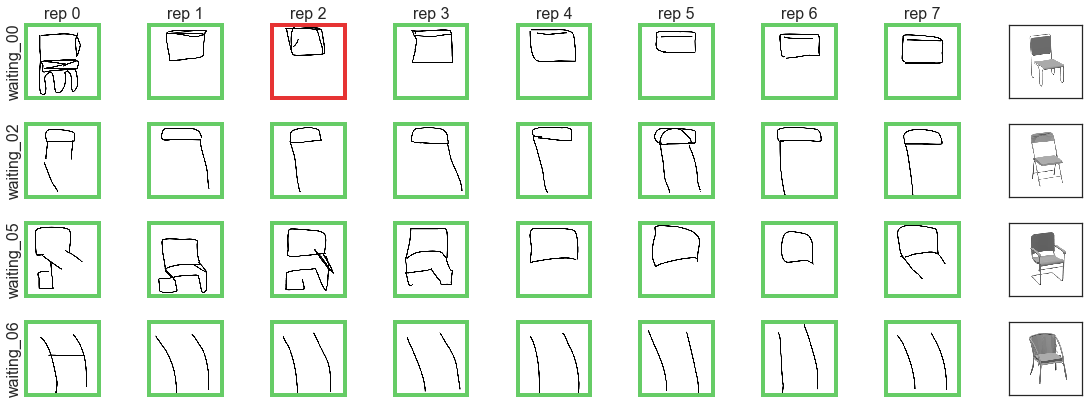

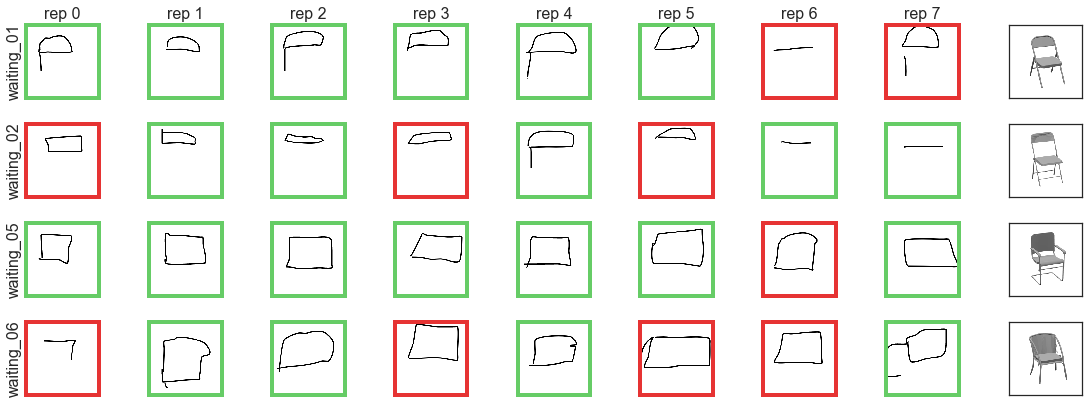

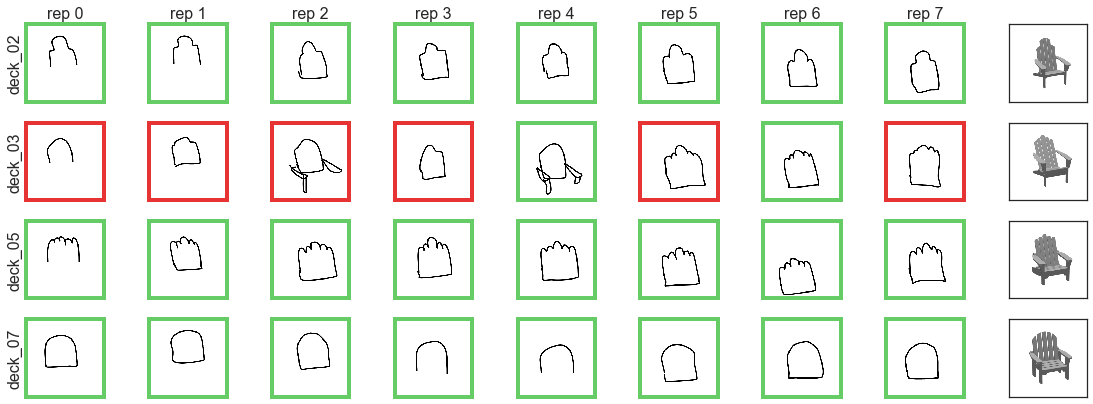

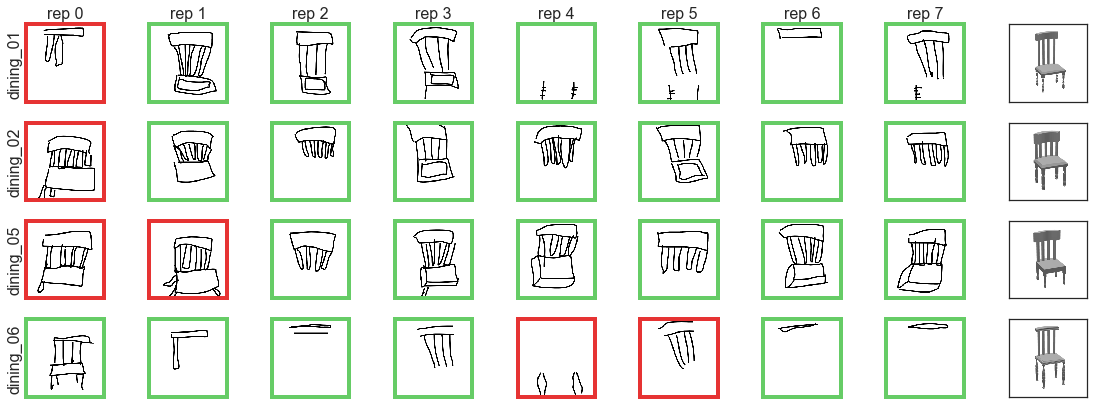

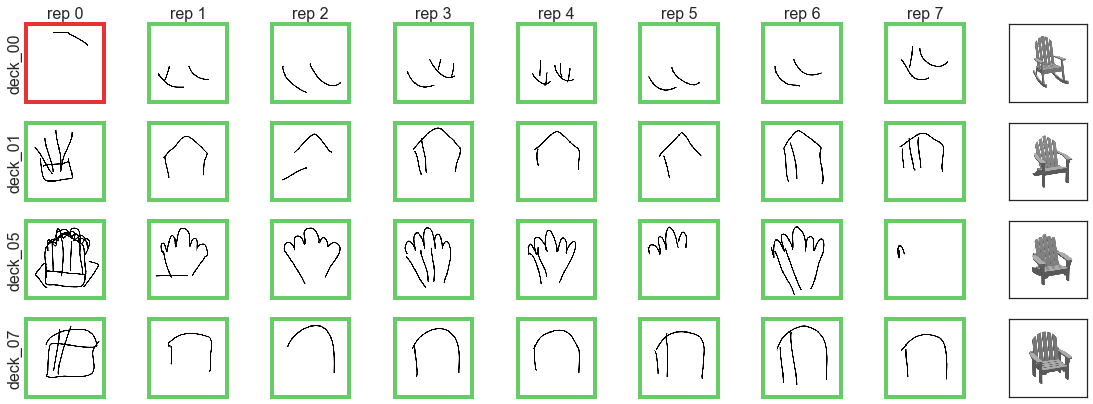

In [168]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 0
        textsize=12
        fig = plt.figure(figsize=(16,6))
        for i,_d in _D.iterrows():
            true_index = new_index[_i]
            if _i%8 == 0:
                target = _d['target']
                dir_path = 'chairs1k_pilot'
                png_name = target + '.png'
                path = os.path.join(dir_path, png_name)
                im = Image.open(path)
                cropped_im = im.crop((350, 150, 600, 400))
                p = plt.subplot(4,9,true_index+8)
                plt.imshow(cropped_im)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,9,true_index)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i < 8) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if _i%8==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()

##### print control sketches in post phase next to repeated sketches

Printing out sketches from game: 7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82
Printing out sketches from game: 5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9
Printing out sketches from game: 3176-1391c021-32cc-4034-8811-4ddafef4280f
Printing out sketches from game: 1217-816328d8-5486-410a-b18e-9578493b0f31
Printing out sketches from game: 1555-977bf072-b352-44e5-b00e-317349ddc158
Printing out sketches from game: 3663-5a7299be-30cf-4686-939e-b2f163df6889
Printing out sketches from game: 8573-60132f17-e4db-4d3e-a49f-4b17867f32d0


ValueError: max() arg is an empty sequence

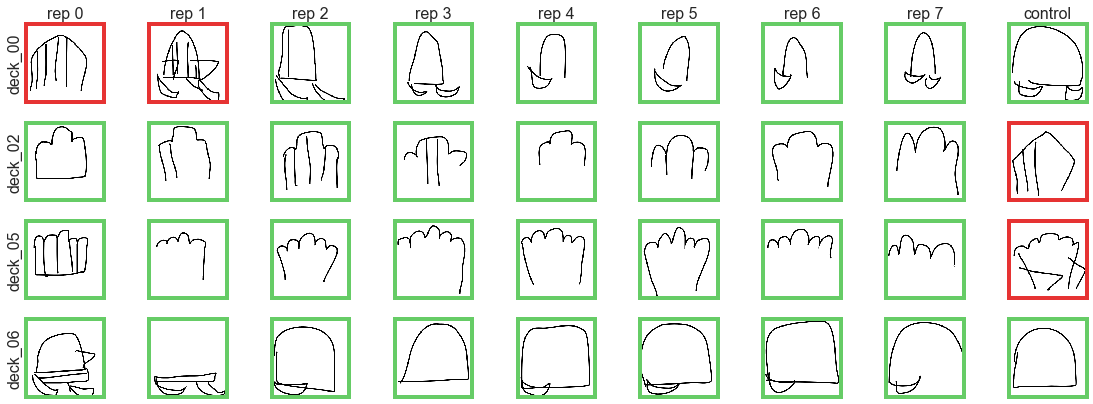

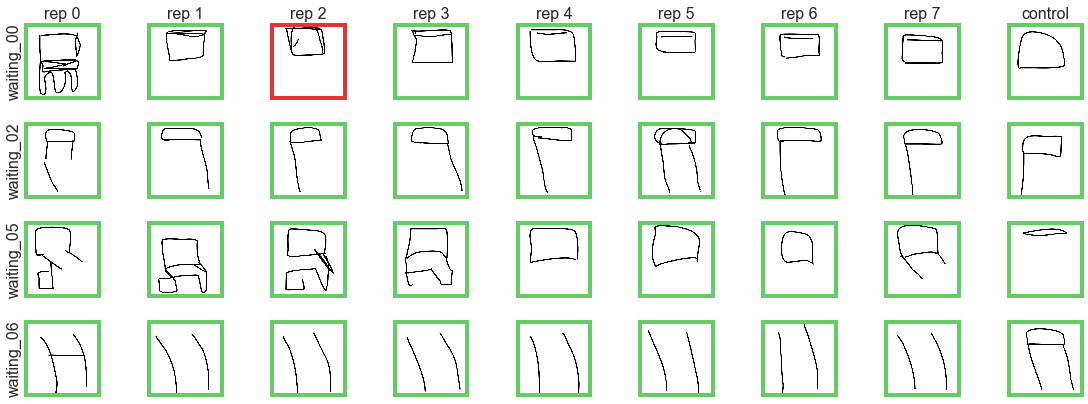

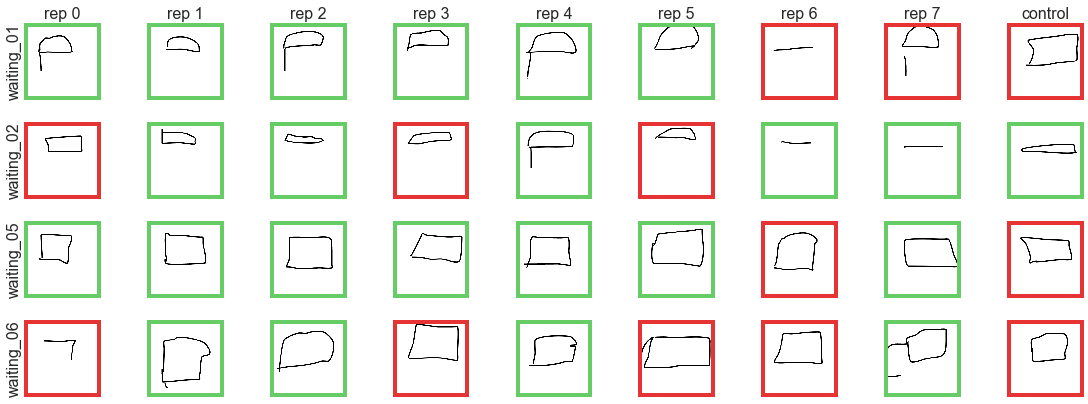

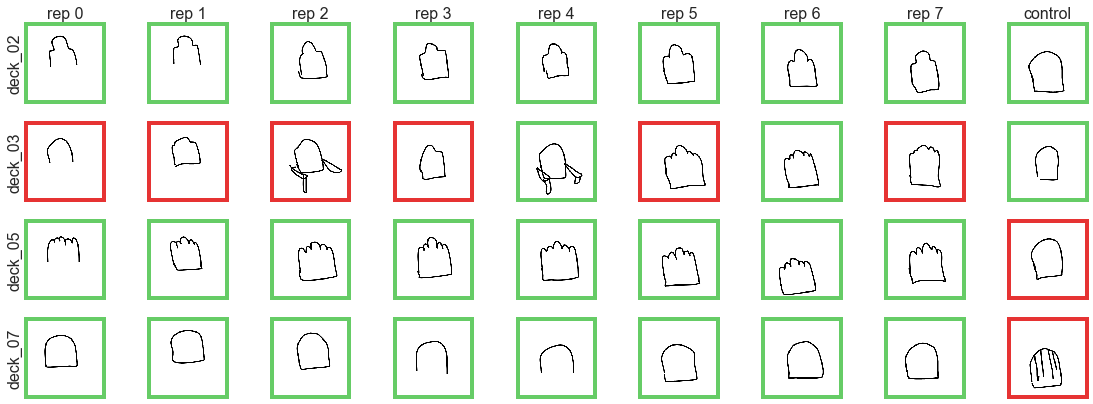

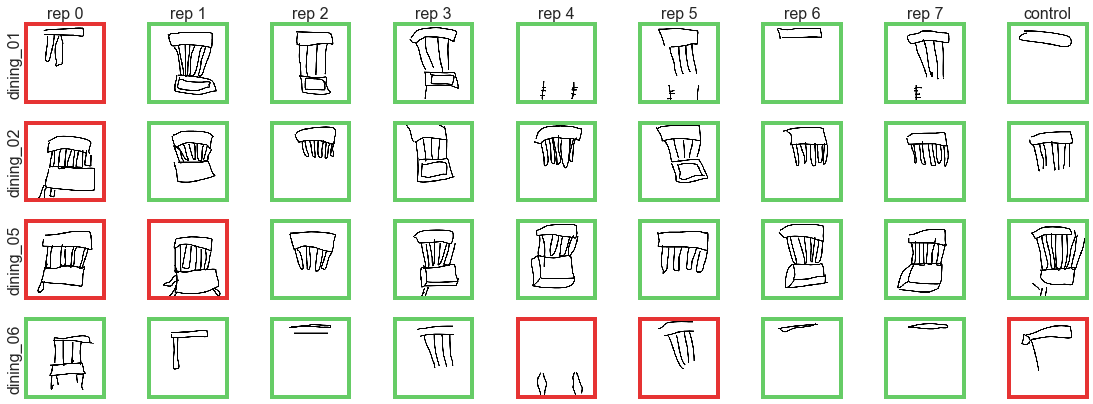

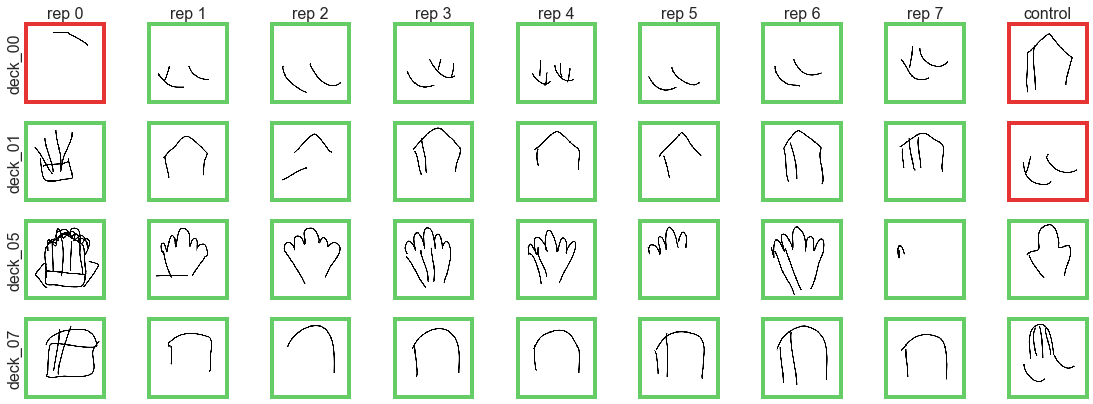

In [171]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        D_ = D[(D.condition=='control') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 0
        control_index = 0
        textsize=12
        fig = plt.figure(figsize=(16,6))
        for i,_d in _D.iterrows():
            true_index = new_index[_i]
            if _i%8 == 0:
                target = _d['target']
                
                D__ = D_[D_.phase == 'post']
                imgData = D__['png'].iloc[control_index]
                filestr = base64.b64decode(imgData)
                fname = 'sketch.png'
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                textsize = 16
                # first plot the target
                im = Image.open(fname)   
                
                p = plt.subplot(4,9,true_index+8)
                plt.imshow(im)
                if (_i < 8):
                    plt.title('control' ,fontsize=textsize)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
                outcome = D__['outcome'].iloc[control_index]
                if outcome == 1:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.4,0.8,0.4))
                        p.spines[s].set_linewidth(4)                               
                else:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.9,0.2,0.2))
                        p.spines[s].set_linewidth(4)    
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,9,true_index)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i < 8) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if _i%8==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)
                control_index = control_index + 1

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()